In [5]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import pandas as pd
%matplotlib inline

In [6]:
import configparser
import warnings
from pymongo import MongoClient

warnings.filterwarnings("ignore", category=DeprecationWarning)

config = configparser.ConfigParser()
config.read('config.ini')
host = config['DEFAULT']['IP']
port = config['DEFAULT']['MongoDB-Port']

client = MongoClient(host, int(port))
db = client['mediacloud']

In [7]:
col_names = [
    'dv', 
    'fv',
    'dv-fv'
]

In [9]:
df = pd.DataFrame()
for col_name in col_names:
    df_col = pd.DataFrame(list(db[col_name].find()))
    df = pd.concat([df, df_col], axis=0)
    
# 2018
df = df[df['publish_date'].str.contains('2018') & (df['text'].str.strip() != '')]

len(df)

5699

In [10]:
df['text']

3857    WHEN it comes to New Year’s resolutions in Bat...
3858    A STRING of men has faced Townsville Magistrat...
3859    This week, the Argus is looking back at some o...
3860    A man charged with the murder of a woman in ce...
3861    A man accused of killing a woman who made a de...
3862    A service, which gives vital support to women ...
3863    Charles McKenzie Ross Evans exists Bendigo Mag...
3864    Bryan Llenas of Fox News reports on the traged...
3866    Bendigo residents on low incomes will be able ...
3867    Hundreds of women who have experienced violenc...
3868    Liverpool defender Jon Flanagan kicked his gir...
3870    STRAIGHT OUTTA YOUTHLINKS: Deb Longhurst is co...
3872    An Illawarra man who dodged domestic violence ...
3873    A Ravenswood man who pleaded guilty to assault...
3874    Yvonne Wilson is hoping to turn a little idea ...
3876    Nelly Yoa's heartfelt and thoughtful article (...
3877    A 39-year-old woman has been charged with the ...
3879    Yvonne

In [11]:
df.iloc[0]['text']

'WHEN it comes to New Year’s resolutions in Bathurst, improving health is at the top of the list for most people. It comes as no surprise that this was a popular answer to the question of ‘What’s your New Year’s resolution?’, as statistics from around the world often favour this resolution. Mayor Graeme Hanger was one of those in Bathurst who wanted to focus on his health in 2018. “[My resolutions are] the old traditional ones: lose a bit of weight, get fit and an apple a day keeps the doctor away,” he said. He also hoped to spend more time with his family this year. “With 24 grandchildren, we’ve got to try to catch up with them all,” he said. Member for Bathurst Paul Toole also jumped on board the health and fitness bandwagon. “For 2018, my New Year’s resolution is to get fitter,” he said. Mr Toole also wants to make a difference in his community in the new year, setting himself a very ambitious career-related goal. “I’ve set a goal to make a minimum of one funding announcement a mont

In [12]:
df['text'] = df['text'].str.replace('\n \r', '')
#df['text'].str
#df['text'].str.rsplit()


In [13]:
df.to_csv('output/csv/stories.csv', mode='w', columns=['publish_date','title','text'], index=False)

In [14]:
stories = pd.read_csv("output/csv/stories.csv",error_bad_lines=False,usecols =["text"])
stories.head()

,text
0,WHEN it comes to New Year’s resolutions in Bat...
1,A STRING of men has faced Townsville Magistrat...
2,"This week, the Argus is looking back at some o..."
3,A man charged with the murder of a woman in ce...
4,A man accused of killing a woman who made a de...


In [15]:
stories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5699 entries, 0 to 5698
Data columns (total 1 columns):
text    5699 non-null object
dtypes: object(1)
memory usage: 44.6+ KB


In [16]:
#Deleting dupliate headlines(if any)
stories[stories['text'].duplicated(keep=False)].sort_values('text').head(8)

,text
5244,1 in 6 women experience physical and/or sexual...
5246,1 in 6 women experience physical and/or sexual...
739,A 20-YEAR-OLD Brisbane man has been charged wi...
740,A 20-YEAR-OLD Brisbane man has been charged wi...
5581,A 23-year-old St Arnaud man has been arrested ...
4708,A 23-year-old St Arnaud man has been arrested ...
3994,A 72-year-old man has been killed and his elde...
3992,A 72-year-old man has been killed and his elde...


In [17]:
stories = stories.drop_duplicates('text')

In [18]:
#remove null values
stories['text'].isnull().sum()
stories.dropna(inplace=True)

# NLP
Preparing data for vectorizaion
However, when doing natural language processing, words must be converted into vectors that machine learning algorithms can make use of. If your goal is to do machine learning on text data, like tweets or anything else, you need to convert the text data into numbers. This process is sometimes referred to as “embedding” or “vectorization”.

In terms of vectorization, it is important to remember that it isn’t merely turning a single word into a single number. While words can be transformed into numbers, an entire document can be translated into a vector. Not only can a vector have more than one dimension, but with text data vectors are usually high-dimensional. This is because each dimension of your feature data will correspond to a word, and the language in the documents you are examining will have thousands of words.

# TF-IDF
In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. Nowadays, tf-idf is one of the most popular term-weighting schemes; 83% of text-based recommender systems in the domain of digital libraries use tf-idf.

Variations of the tf–idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query. tf–idf can be successfully used for stop-words filtering in various subject fields, including text summarization and classification.

One of the simplest ranking functions is computed by summing the tf–idf for each query term; many more sophisticated ranking functions are variants of this simple model.

In [19]:
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
desc = stories['text'].values
vectorizer = TfidfVectorizer(stop_words = stop_words)
X = vectorizer.fit_transform(desc)

In [20]:
word_features = vectorizer.get_feature_names()
print(len(word_features))
print(word_features[0:300])
#remove numbers features except '1800respect'
#del(word_features[0:201])
#word_features[0:201]
#word_features.insert(0,'1800respect')
#print(word_features[0:300])

49910
['00', '000', '0001', '000km', '000sq', '000th', '002', '003', '004', '007', '009', '00am', '00pm', '01', '010', '011', '015', '017', '017mg', '018', '01g', '02', '020', '0200', '024', '025', '0274', '02am', '02pm', '03', '030', '031', '0311', '033', '035', '0377', '038', '039', '04', '0400', '0403', '0405', '0407', '0408', '0410191772', '0413', '0417', '0418', '0418911728', '0419', '0419672697', '0420', '0421', '0427', '0428', '0429', '0430', '0431', '0432', '0435', '0437', '0438', '0439', '0447', '0448', '0448396244', '045', '0451', '0455', '0456', '0458', '0466', '047', '0475', '048', '0487', '0488', '0497172808', '04pm', '05', '0500', '052', '053', '054', '0540', '0542', '055', '0555', '0562', '058', '059', '05pm', '06', '060', '061', '062', '063', '065', '066', '0671', '068', '06am', '07', '070', '0700', '071', '072', '074', '0746421354', '075', '077', '078', '08', '080', '0800', '083', '085', '087', '088', '0899', '08am', '09', '090', '0900', '091', '092', '093', '094', '09

# Stemming

Stemming is the process of reducing a word into its stem, i.e. its root form. The root form is not necessarily a word by itself, but it can be used to generate words by concatenating the right suffix. For example, the words fish, fishes and fishing all stem into fish, which is a correct word. On the other side, the words study, studies and studying stems into studi, which is not an English word.

# Tokenizing
Tokenization is breaking the sentence into words and punctuation


In [21]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

# Vectorization with stop words(words irrelevant to the model), stemming and tokenizing

In [22]:
vectorizer2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize)
X2 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names()
print(len(word_features2))
print(word_features2[0:200])

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


32383
["''", "'a", "'alcohol", "'anecdote'", "'ani", "'bi", "'custodian", "'d", "'data'", "'do", "'everi", "'evid", "'f", "'g", "'get", "'great", "'hates'", "'he", "'i", "'i'v", "'it", "'mi", "'more", "'natural'", "'o", "'peopl", "'pleas", "'restor", "'s", "'selfies'", "'sometim", "'somewher", "'take", "'that", "'the", "'there", "'these", "'this", "'tri", "'we", "'when", "'women", "'x", "'you", 'aa', 'aaa', 'aaah', 'aacta', 'aad', 'aaf', 'aah', 'aami', 'aandrea', 'aap', 'aarn', 'aaron', 'aarong', 'aarti', 'aashi', 'aasw', 'aat', 'aaypic', 'ab', 'aba', 'abac', 'aback', 'abacus', 'abalon', 'abandon', 'abassador', 'abat', 'abattoir', 'abaya', 'abb', 'abba', 'abbey', 'abbeyfield', 'abbi', 'abbington', 'abbotsburi', 'abbotsford', 'abbott', 'abbrevi', 'abc', 'abcc', 'abctv', 'abdel', 'abdeslam', 'abdic', 'abdo', 'abdollahian', 'abdomen', 'abdomin', 'abduct', 'abdul', 'abdulali', 'abdullah', 'abe', 'abel', 'abela', 'abercrombi', 'aberdeen', 'aberglasslyn', 'abermain', 'aberr', 'abet', 'abetz'

In [23]:
vectorizer3 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X3 = vectorizer3.fit_transform(desc)
words = vectorizer3.get_feature_names()

In [35]:
#calculate word frequency for finding max_feature value
from collections import Counter
print(Counter(words).most_common(3))

[('abc', 1), ('abl', 1), ('aborigin', 1)]


# K-means clustering

# Elbow method to select number of clusters
This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. More precisely, if one plots the percentage of variance explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion". This "elbow" cannot always be unambiguously identified. Percentage of variance explained is the ratio of the between-group variance to the total variance, also known as an F-test. A slight variation of this method plots the curvature of the within group variance.

Basically, number of clusters = the x-axis value of the point that is the corner of the "elbow"(the plot looks often looks like an elbow)

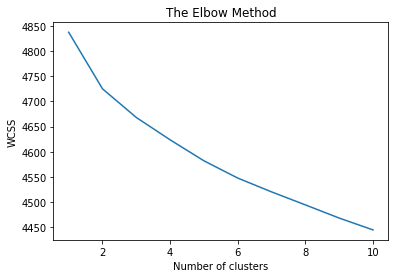

In [36]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X3)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

In [ ]:
#As no major elbow have been generated/As more than one elbows have been generated, I will have to select right amount of clusters 
#by trial and error. So, I will showcase the results of different amount of clusters to 
#find out the right amount of clusters. 

# 3 Clusters

In [37]:
kmeans = KMeans(n_clusters = 3, n_init = 20, n_jobs = 1) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(X3)
# We look at 3 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : said, women, s, violenc, famili, peopl, communiti, domest, year, ms, servic, support, children, help, work, govern, need, say, health, mr, australia, day, homeless, time, new
1 : polic, court, said, man, charg, alleg, year, woman, mr, magistr, old, assault, order, violenc, crime, incid, offic, sentenc, arrest, told, s, offenc, domest, bail, victim
2 : bound, shown, pleas, note, onlin, condit, discuss, comment, term, said, s, violenc, polic, domest, communiti, women, local, peopl, servic, nsw, year, support, orang, famili, council


# 5 Clusters

In [24]:
kmeans = KMeans(n_clusters = 5, n_init = 20, n_jobs = 1)
kmeans.fit(X3)
# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : said, s, peopl, year, communiti, mr, famili, homeless, servic, govern, health, work, children, support, violenc, help, new, ms, hous, say, time, need, australia, australian, school
1 : bound, shown, pleas, onlin, note, condit, discuss, comment, term, said, s, violenc, domest, communiti, women, peopl, servic, polic, support, local, year, orang, nsw, famili, program
2 : women, violenc, said, s, famili, domest, men, ms, communiti, abus, support, servic, peopl, year, victim, children, help, need, day, ribbon, say, work, t, partner, sexual
3 : court, man, polic, said, charg, alleg, magistr, woman, year, sentenc, mr, old, told, order, assault, bail, arrest, s, violenc, appear, victim, heard, partner, befor, guilti
4 : polic, said, crime, offic, incid, violenc, year, report, offenc, domest, s, cent, area, famili, communiti, assault, district, nsw, command, investig, sergeant, increas, inspector, number, relat


# 7 Clusters

In [25]:
kmeans = KMeans(n_clusters = 7, n_init = 20, n_jobs = 1)
kmeans.fit(X3)
# We look at 7 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : polic, man, alleg, charg, court, arrest, old, woman, said, incid, bail, appear, year, offic, assault, s, home, report, violenc, investig, magistr, domest, mr, befor, scene
1 : court, said, man, sentenc, magistr, polic, order, mr, told, year, jail, woman, victim, guilti, heard, ms, month, judg, partner, plead, charg, violenc, assault, time, murder
2 : polic, crime, said, offic, violenc, incid, offenc, cent, communiti, report, domest, area, year, assault, district, increas, s, famili, nsw, number, inspector, command, region, statist, rate
3 : women, violenc, said, s, famili, domest, men, ms, communiti, support, abus, servic, peopl, year, children, help, need, victim, ribbon, day, work, say, partner, white, t
4 : homeless, peopl, hous, said, accommod, sleep, servic, afford, support, s, help, live, street, provid, communiti, cent, ms, women, famili, year, home, need, crisi, children, increas
5 : bound, shown, pleas, onlin, note, condit, discuss, comment, term, said, s, violenc, communi

# 6 Clusters

In [ ]:
kmeans = KMeans(n_clusters = 6, n_init = 20, n_jobs = 1)
kmeans.fit(X3)
# We look at 6 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

# 8 Clusters

In [ ]:
kmeans = KMeans(n_clusters = 8, n_init = 20, n_jobs = 1)
kmeans.fit(X3)
# Finally, we look at 8 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))